# The Changing Cost of Slavery 
## Andrea Hayes
### July 31, 2024

# Introduction 
* Introduction (an overview of your entire project, your research topic and question,
your motivation to study this topic, and any prior related work)

* Overview: Slavery has a dark past in the history of America. (400 more words here about history) The political climate was changing with the looming war over slavery and what rights the states had. 

* Research Questions: Did the geographic distribution of buyers or sellers of slaves change as the civil war approached? How far did the average person travel to buy or sell a slave in New Orleans? 

* Motivation: As we live through historical events it seems obvious or sometimes not so obvious about the decisions we make based on how we think the future will be. If we think an economic collapse is coming we will save more money. But we don't always have the foresight for these decisions. Coming across the dataset with slavery from 1856 - 1861 made me wonder if men of the time changed there decisions based on the political climate. Did they think the south would win the war and made no changes to how they purchased slaves? Or did they suspect the north would win an unload their slaves? Or did they only purchase necessary slaves waiting to see which way the winds would blow. Considering this dataset is from New Orleans, which is in the deep south, was there a different mindset.  

# Methods
* Methods (explain your data and your analytical process)
* This dataset has the records of 9,599 slaves sold in New Orleans from 1856 - 1861. It has a wide variety of information from the buyer, seller and slave on each sale. It includes the buyers and sellers names and where they are from. For the slaves it includes their gender, age, amount sold for, and other financial information.  
* For the research questions I'm attempting to answer I found it best to focus on the buyer's origin and the seller's origin. Knowing their origins would give me a geographical region of where buyers and sellers were coming from.  

# Results
* Results (lay out your data exploration, your findings, and your visuals)
* 
* Vis 1: Top 5 places buyers were from each year
* Vis 2: Top 5 places sellers were from each year
* Vis 3: Average distances between buying and sellers from New Orleans 



In [77]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Retrieve html code from CORGIS
url = "https://corgis-edu.github.io/corgis/csv/"
response = requests.get(url)
html_content = response.text

#Parse the html and create a list
soup = BeautifulSoup(html_content, 'html.parser')
h3_tags = soup.find_all('h3')

#Make list of all dataset names that CORGIS has
corgis_list = [tag.get_text() for tag in h3_tags]


#Takes in number of dataset and returns a Pandas dataframe
def pdcorgis(dataset_name):

    #Convert to lowercase and add _ to needed datasets
    dataset_name_lower = dataset_name.lower().replace(' ', '_')
    # print(dataset_name_lower)
    
    #Get HTML from CORGIS page
    dataset_url = f"https://corgis-edu.github.io/corgis/csv/{dataset_name_lower}/"
    dataset_response = requests.get(dataset_url)
    dataset_html_content = dataset_response.text

    #Parse the HTML and find links
    dataset_soup = BeautifulSoup(dataset_html_content, 'html.parser')
    links = dataset_soup.find_all('a')

    #Find download link
    download_link = None
    for link in links:
        if link.has_attr('download'):
            download_link = link['href']
            break

    if download_link is None:
        raise ValueError("Download link for {dataset_name} not found")
    
    #Get link to use for csv
    csv_url = f"https://corgis-edu.github.io/corgis/csv/{dataset_name_lower}/{download_link}"

    #Read the csv file into Pandas
    corgis_dataframe = pd.read_csv(csv_url)

    return corgis_dataframe






In [82]:
slavery_data = pdcorgis(corgis_list[47]) 

# print(slavery_data.head()) 
print(slavery_data)
# 


# Replace dots in date with with NaN
slavery_data['Transaction.Date'].replace('.', np.nan, inplace=True)

# Convert the 'Transaction.Date' column to datetime, errors='coerce' will convert invalid dates to NaT
slavery_data['Transaction.Date'] = pd.to_datetime(slavery_data['Transaction.Date'], format='%m/%d/%Y', errors='coerce')

# Get the year
year = slavery_data['Year'] = slavery_data['Transaction.Date'].dt.year
# print(year)

# Get the buyer city
# buyer_city = slavery_data['BuyerCity'] = slavery_data['Buyer.Origin'].str.split(',').str[0]
# print("Buyer City" , buyer_city)

# seller_city = slavery_data['SellerCity'] = slavery_data['Seller.Origin'].str.split(',').str[0]
# print(seller_city)

years_wanted = [1856, 1857, 1858, 1859, 1860, 1861]
filtered_years = slavery_data[slavery_data['Year'].isin(years_wanted)]
# print("Filtered_years" , filtered_years)

     Buyer.County of Origin         Buyer.Full Name      Buyer.Origin  \
0                   Unknown            Maria Hopson  Unknown, Unknown   
1               New Orleans      Peyton N. Reynolds   New Orleans, LA   
2               New Orleans        Heloise Bagneris   New Orleans, LA   
3                 Jefferson       Francis Dugue Jr.     Jefferson, LA   
4               New Orleans          Anthony O'Dowd   New Orleans, LA   
...                     ...                     ...               ...   
9594            New Orleans             Isaac Bloom   New Orleans, LA   
9595            New Orleans  Jean Jacques Planchard   New Orleans, LA   
9596            New Orleans     Matthew Jules Bujac   New Orleans, LA   
9597            New Orleans      Sarah Ann Chadwick   New Orleans, LA   
9598            New Orleans           Pierre Balois   New Orleans, LA   

     Buyer.State of Origin Seller.County of Origin        Seller.Full Name  \
0                  Unknown                 Un

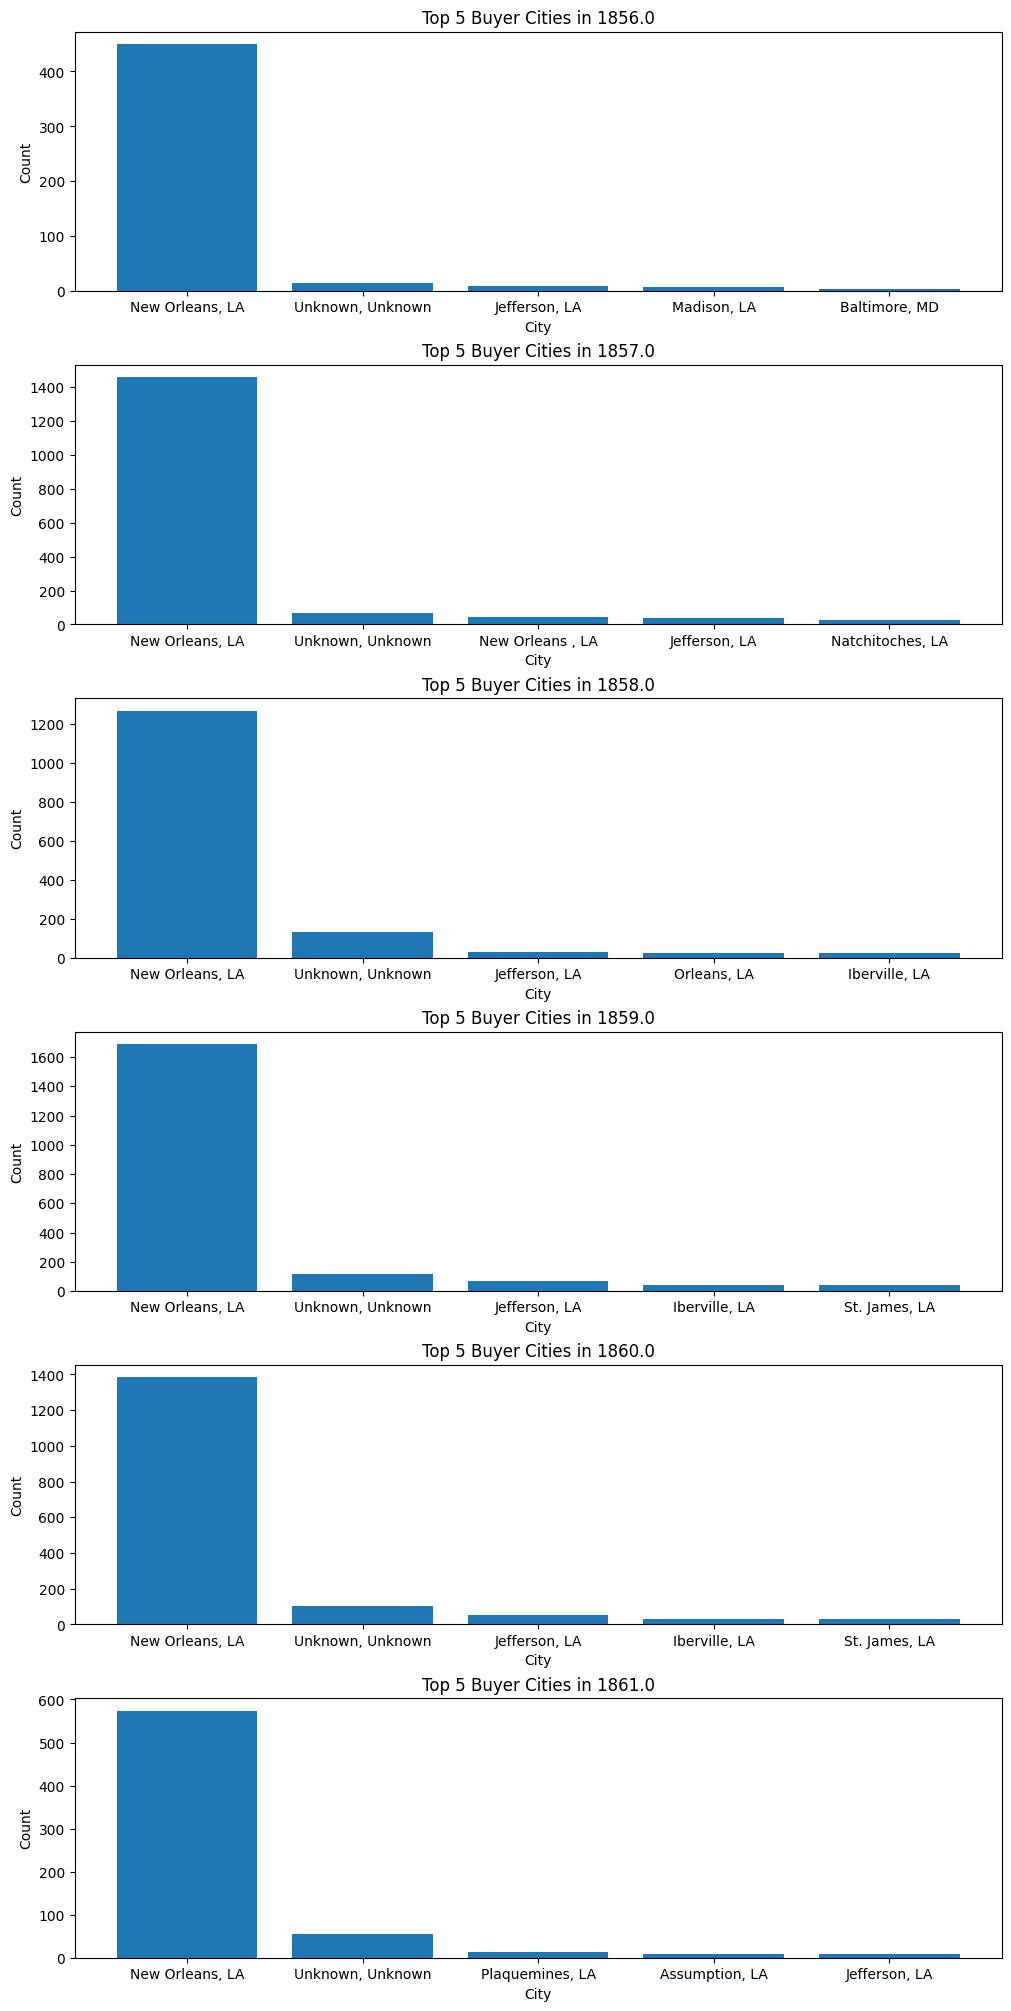

In [80]:
#Top 5 Cities Buyer's were from for 1856 - 1861
# Group by year and get top 5 cities for each year
top_buyer_cities_per_year = filtered_years.groupby(['Year', 'Buyer.Origin']).size().groupby(level=0).nlargest(5).reset_index(level=0, drop=True).reset_index(name='Count')

# Plotting
years = filtered_years['Year'].unique()
# print(years)
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 20), constrained_layout=True)

for i, year in enumerate(years):
    top_cities = top_buyer_cities_per_year[top_buyer_cities_per_year['Year'] == year]
    axes[i].bar(top_cities['Buyer.Origin'], top_cities['Count'])
    axes[i].set_title(f'Top 5 Buyer Cities in {year}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('City')

plt.show()

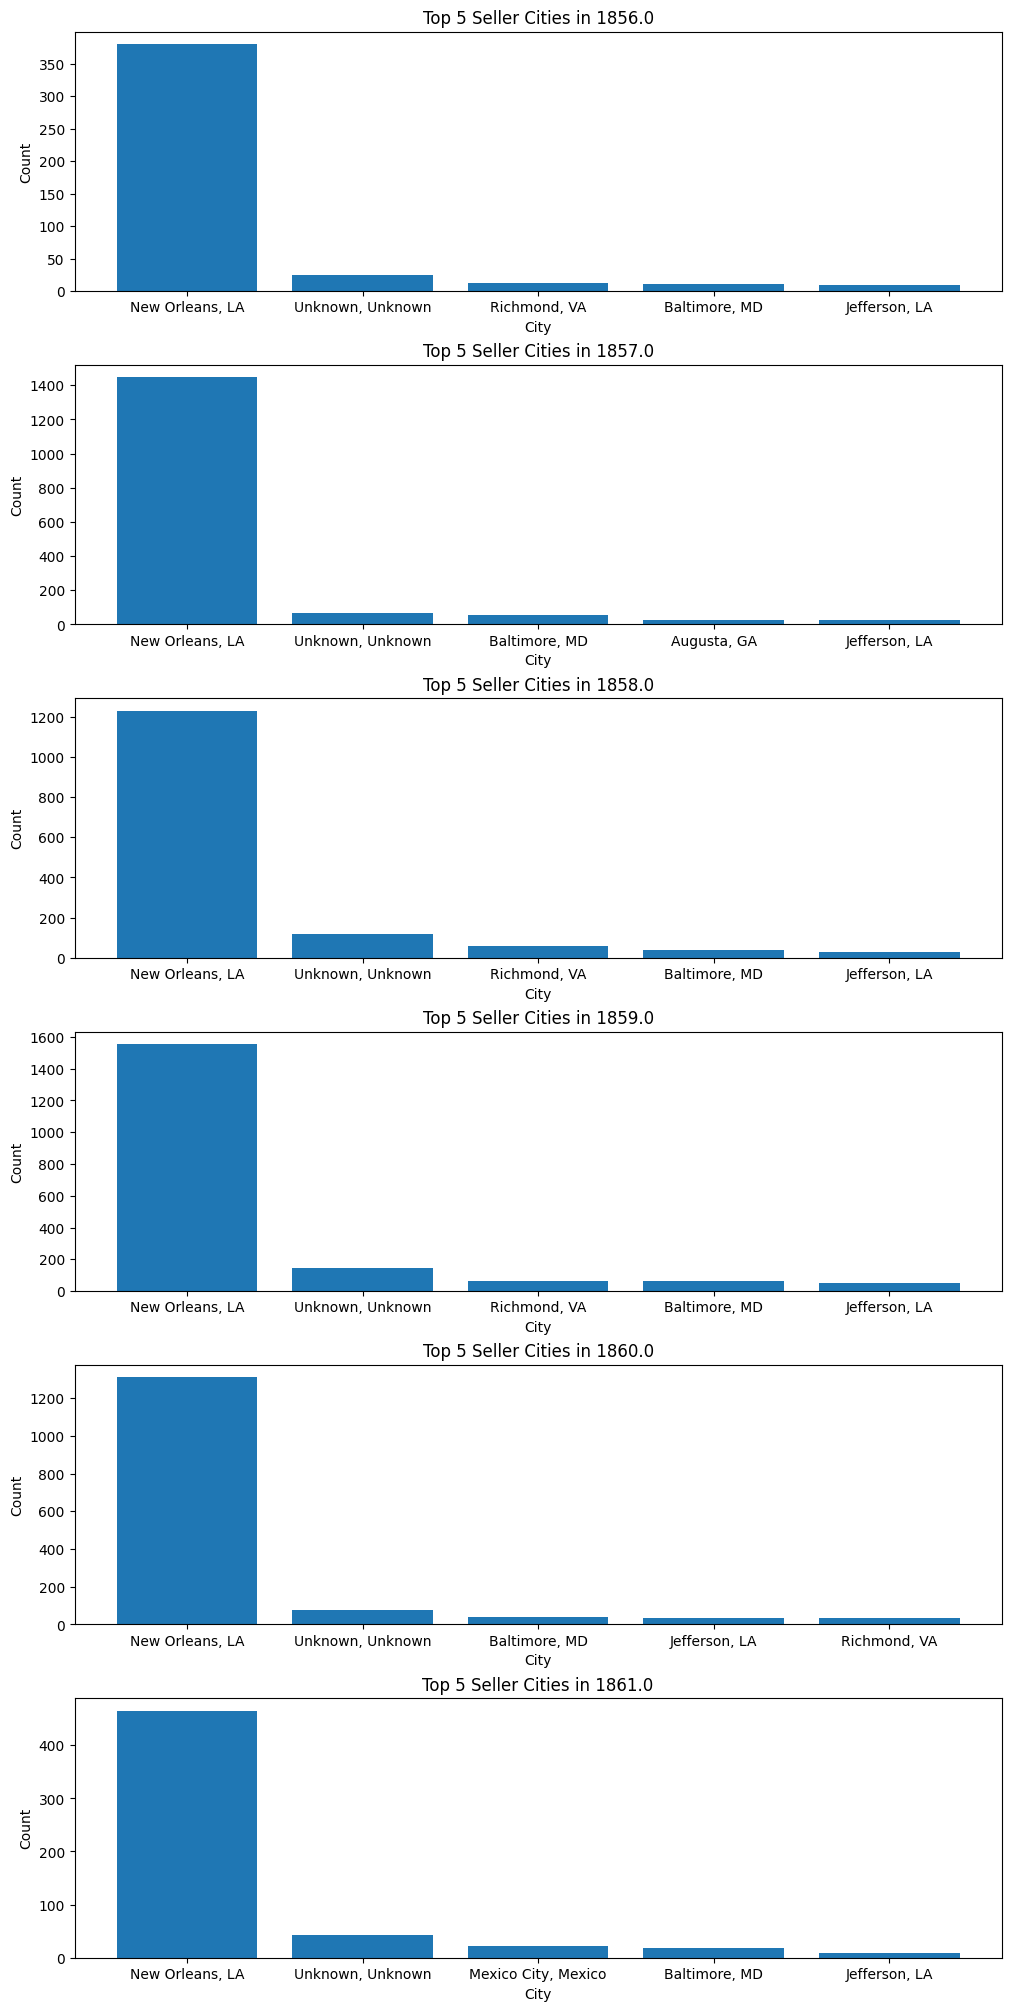

In [81]:
#Top 5 Cities Seller's were from 1856 - 1861 
top_seller_cities_per_year = filtered_years.groupby(['Year', 'Seller.Origin']).size().groupby(level=0).nlargest(5).reset_index(level=0, drop=True).reset_index(name='Count')

fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 20), constrained_layout=True)

for i, year in enumerate(years):
    top_cities = top_seller_cities_per_year[top_seller_cities_per_year['Year'] == year]
    axes[i].bar(top_cities['Seller.Origin'], top_cities['Count'])
    axes[i].set_title(f'Top 5 Seller Cities in {year}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('City')

plt.show()

# Discussion
* Discussion (what does your analysis show, what is the big picture, and how are
these findings useful?) 